In [1]:
import os
import warnings
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow as tf

# print(os.listdir('/kaggle/input/'))

warnings.filterwarnings("ignore", message="n_fft=1024 is too large for input signal")
warnings.filterwarnings("ignore", message="n_fft=2048 is too large for input signal")

The `augment_audio` function randomly applies audio augmentation techniques to the input audio data, `y_audio`, with sampling rate `sr`. It uses `time_stretch` to speed up or slow down the audio by a random factor between 0.8 and 1.2, and `pitch_shift` to adjust the pitch by a random number of semitones between -2 and 2. These augmentations help increase data variability for model training.

In [2]:
def augment_audio(y_audio, sr):
    # Randomly apply time stretching with a rate between 0.8 and 1.2
    if np.random.rand() > 0.5:
        y_audio = librosa.effects.time_stretch(y_audio, rate=np.random.uniform(0.8, 1.2))

    # Randomly apply pitch shifting with n_steps between -2 and 2
    if np.random.rand() > 0.5:
        y_audio = librosa.effects.pitch_shift(y_audio, sr=sr, n_steps=np.random.randint(-2, 3))
    
    return y_audio


This function processes an audio file by first loading it, applying augmentation (time-stretching and pitch-shifting), and then converting it into a Mel-spectrogram, which is a time-frequency representation. It also ensures the Mel-spectrogram is padded or truncated to a desired length and adds a channel dimension, making it suitable for input into neural networks.s.

In [3]:
# Function to extract Mel-spectrogram from raw audio
def extract_features(file_path, max_length=130):
    """
    Load an audio file, apply augmentation, and convert it to a Mel-spectrogram.
    
    Parameters:
        file_path (str): Path to the audio file.
        max_length (int): Desired length of the Mel-spectrogram.
    
    Returns:
        numpy.ndarray: Mel-spectrogram of the audio file.
    """
    try:
        y, sr = librosa.load(file_path, sr=16000)  # Load audio file
        y = augment_audio(y, sr)  # Apply augmentation
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)  # Convert to Mel-spectrogram
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB scale
        
        # Pad or truncate to max_length (time axis)
        if mel_spec.shape[1] < max_length:
            mel_spec = np.pad(mel_spec, ((0, 0), (0, max_length - mel_spec.shape[1])), mode='constant')
        else:
            mel_spec = mel_spec[:, :max_length]
        
        # Add a channel dimension (1 for grayscale spectrogram)
        mel_spec = np.expand_dims(mel_spec, axis=-1)
        return mel_spec
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

This function prepares the dataset by loading audio files from a specified path, extracting features, and labeling them according to the given target emotions. It ensures that only the selected emotions are included, counts the number of files per category, and returns the features, labels, and category names as numpy arrays.

In [4]:
# Prepare dataset and limit files per category
def prepare_dataset_filtered(dataset_path, target_emotions, max_files_per_category=100):
    """
    Prepare the dataset by extracting features and labels, but only include specific emotions.
    Also, count the total number of files in each target category.

    Parameters:
        dataset_path (str): Path to the dataset folder, organized by subfolders for each category.
        target_emotions (list): List of emotions to include in the dataset.
    
    Returns:
        Tuple: (audio_data, labels, category_names)
    """
    # Get all categories and filter based on the target_emotions list
    categories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    filtered_categories = [c for c in categories if c in target_emotions]
    category_dict = {category: idx for idx, category in enumerate(filtered_categories)}
    
    audio_data, labels = [], []
    category_counts = {category: 0 for category in filtered_categories}  # To count files in each category
    
    for category in filtered_categories:
        category_path = os.path.join(dataset_path, category)
        files = [f for f in os.listdir(category_path) if f.endswith(('.wav', '.mp3', '.flac'))]

        # Limit to max_files_per_category files per category
        # files = files[:max_files_per_category]
        
        # Count the number of files in the current category
        category_counts[category] = len(files)
        
        for file in files:
            file_path = os.path.join(category_path, file)
            features = extract_features(file_path)
            if features is not None:
                audio_data.append(features)
                labels.append(category_dict[category])
    
    # Print the file counts for each category and the total count
    total_files = sum(category_counts.values())
    print("File counts per category:")
    for category, count in category_counts.items():
        print(f"{category}: {count} files")
    print(f"Total files: {total_files}")
    
    return np.array(audio_data), np.array(labels), filtered_categories

This part of the code loads the dataset and splits it into training, validation, and test sets. The train_test_split function ensures that the data is stratified (i.e., each set contains a proportional representation of each emotion), and the shapes of the resulting datasets are printed.

In [5]:
# Specify target emotions
target_emotions = ["Anger", "Happiness", "Sadness", "Neutral"]

# Load dataset
dataset_path = '/kaggle/input/urdu-8emotions-24actors-dataset/normalized'  # Update with your dataset path
audio_data, labels, category_names = prepare_dataset_filtered(dataset_path, target_emotions)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(audio_data, labels, test_size=0.2, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Print dataset shapes after splitting
print(f"Training dataset shape: {X_train.shape}")
print(f"Validation dataset shape: {X_val.shape}")
print(f"Test dataset shape: {X_test.shape}")

File counts per category:
Neutral: 3479 files
Sadness: 3479 files
Happiness: 3480 files
Anger: 3480 files
Total files: 13918
Training dataset shape: (11134, 128, 130, 1)
Validation dataset shape: (1392, 128, 130, 1)
Test dataset shape: (1392, 128, 130, 1)


This code reshapes the dataset to make it compatible with Conv2D layers in a neural network. Initially, the data (`X_train`, `X_val`, `X_test`) is assumed to be in a 2D format (e.g., flattened feature vectors or 2D spectrograms). Since Conv2D layers expect 4D input in the form of `(num_samples, height, width, channels)`, the code reshapes the data into a 4D tensor, where each sample is now represented as a 3D matrix (height, width, 1) with an added channel dimension. The reshaped data can then be used by convolutional layers for further processing. Finally, the reshaped shapes of `X_train`, `X_val`, and `X_test` are printed to verify the transformation.

In [6]:
# X_train is a 2D array where each sample is a flattened feature vector
# We need to reshape it into a 4D tensor for the Conv2D layers
# First, check the shape of X_train
print(f"X_train shape before reshaping: {X_train.shape}")

# Reshape X_train, X_val, X_test to 4D tensor (num_samples, height, width, 1)
# This assumes that X_train[i] is a 2D spectrogram of shape (height, width)
# The final reshaped shape will be (num_samples, height, width, 1)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Verify the reshaped data shape
print(f"X_train shape after reshaping: {X_train.shape}")
print(f"X_val shape after reshaping: {X_val.shape}")
print(f"X_test shape after reshaping: {X_test.shape}")

X_train shape before reshaping: (11134, 128, 130, 1)
X_train shape after reshaping: (11134, 128, 130, 1)
X_val shape after reshaping: (1392, 128, 130, 1)
X_test shape after reshaping: (1392, 128, 130, 1)


This code defines a CNN model for classifying audio spectrograms:

Model Architecture:

Convolutional Layers: The model has three convolutional layers with increasing filters (32, 64, 128), each followed by batch normalization and max pooling to capture features and reduce dimensions.
Global Average Pooling: Summarizes each feature map for a compact output.
Dense Layers: A 256-unit dense layer with dropout for regularization, followed by a final softmax layer for category classification.
Compilation:

The model uses the Adam optimizer with a low learning rate (0.0001) for stable learning and sparse_categorical_crossentropy as the loss for multi-class classification.

In [7]:
# Enhanced model
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2], 1)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(target_emotions), activation='softmax')
])

# Compile model with lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

This code trains and evaluates the CNN model:

Training: The model is trained on X_train and y_train for 20 epochs with a batch size of 32, reserving 10% of the training data for validation.

Evaluation: After training, the model is tested on X_test and y_test, and the test accuracy is printed.

In [12]:
# Train with explicit validation data
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9929 - loss: 0.0214 - val_accuracy: 0.8592 - val_loss: 0.6402
Epoch 2/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9926 - loss: 0.0205 - val_accuracy: 0.8111 - val_loss: 1.2417
Epoch 3/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9901 - loss: 0.0304 - val_accuracy: 0.9346 - val_loss: 0.2890
Epoch 4/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9943 - loss: 0.0164 - val_accuracy: 0.9368 - val_loss: 0.3212
Epoch 5/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9955 - loss: 0.0134 - val_accuracy: 0.9346 - val_loss: 0.3316
Epoch 6/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9965 - loss: 0.0112 - val_accuracy: 0.9468 - val_loss: 0.2546
Epoch 7/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9957 - loss: 0.0111 - val_accuracy: 0.8872 - val_loss: 0.5412
Epoch 8/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9938 - loss: 0.0175 - val_accu

This code evaluates a trained model on the test data and generates performance metrics. First, it predicts the test labels using `model.predict` and converts the probabilities to class labels using `np.argmax`. It then computes a confusion matrix and visualizes it as a heatmap with `sns.heatmap`, showing how well the model's predictions match the true labels. Next, the model's loss and accuracy on the test data are evaluated using `model.evaluate`, and these metrics are printed. Finally, the code plots the training, validation, and test accuracy/loss over epochs to visualize the model's performance during training, helping to assess if it's overfitting or underperforming.

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


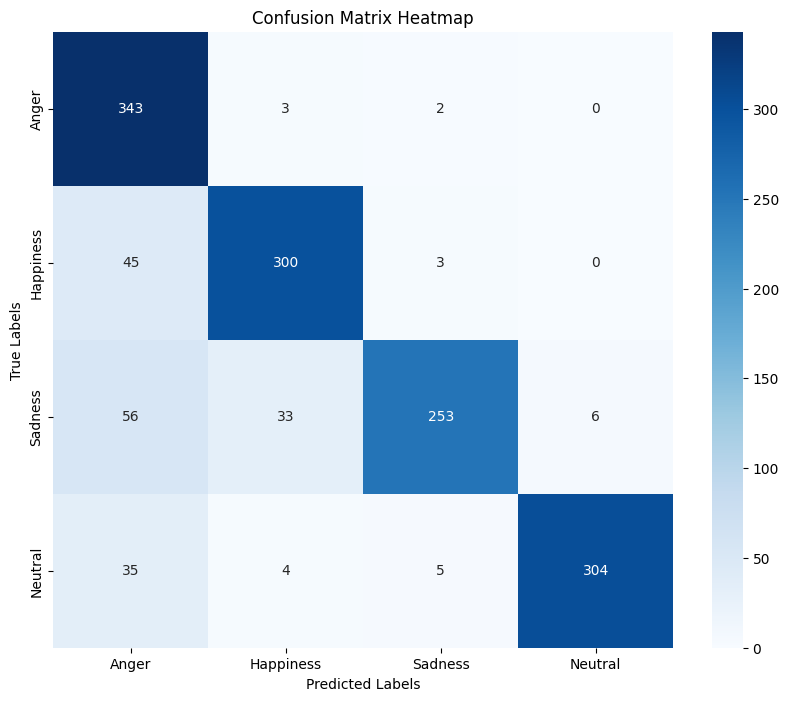

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8579 - loss: 1.0624
Test Accuracy: 86.21%
Test Loss: 0.9898


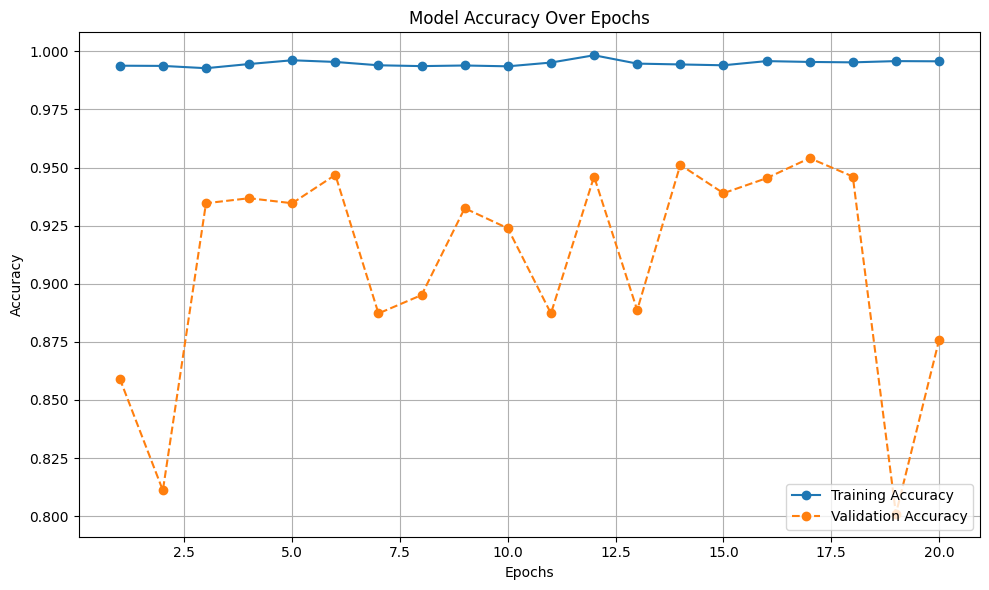

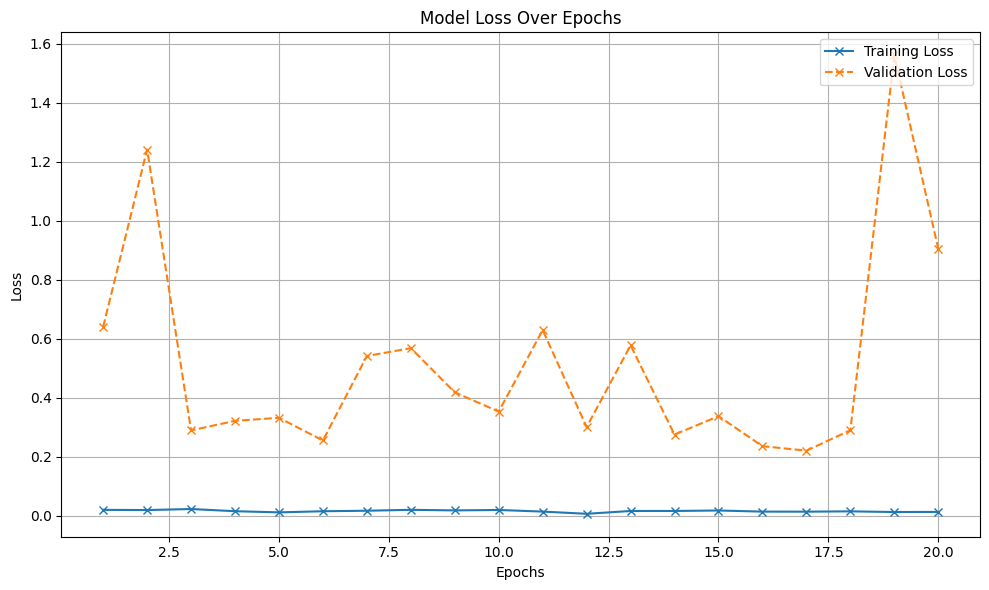

In [13]:
# Predict on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_emotions, yticklabels=target_emotions)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Evaluate on the test data for loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Plot training, validation, and test accuracy
plt.figure(figsize=(10, 6))
epochs = range(1, len(history.history['accuracy']) + 1)

# Training Accuracy
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', linestyle='-', marker='o')
# Validation Accuracy
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', marker='o')
# Test Accuracy (single value)
# plt.axhline(y=test_accuracy, color='r', linestyle='-.', label=f'Test Accuracy: {test_accuracy * 100:.2f}%')

plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot training, validation, and test loss
plt.figure(figsize=(10, 6))

# Training Loss
plt.plot(epochs, history.history['loss'], label='Training Loss', linestyle='-', marker='x')
# Validation Loss
plt.plot(epochs, history.history['val_loss'], label='Validation Loss', linestyle='--', marker='x')
# Test Loss (single value)
# plt.axhline(y=test_loss, color='r', linestyle='-.', label=f'Test Loss: {test_loss:.4f}')

plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()